In [1]:
import functools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns

sns.set()

Say we have some random variable $X$ distributed as

$X \sim Normal(\mu, \Sigma)$

and we put it through a transformation $g$, and end up with

$\tilde{X} = g(x)$

What will the probability distribution of $\tilde{X}$ be?

In [2]:
mu = jnp.zeros(2)
cov = jnp.array([[0.5, 0.2], [0.2, 0.1]])
distribution = dist.MultivariateNormal(mu, cov)
rng_key = jax.random.PRNGKey(2)
samples = distribution.sample(rng_key, sample_shape=(1000,))

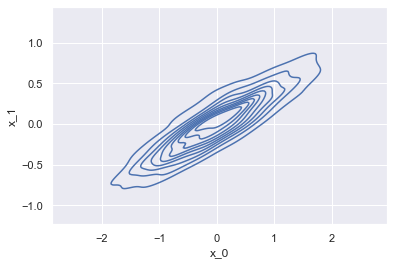

In [3]:
fig, ax = plt.subplots()

data = pd.DataFrame(samples, columns=["x_0", "x_1"])
sns.kdeplot(data=data, x="x_0", y="x_1");

In [4]:
def transformation(x):
    return jnp.asarray([jax.scipy.special.expit(x[0]), jnp.exp(x[1])])

In [5]:
pushforward_samples = jax.vmap(transformation)(samples)

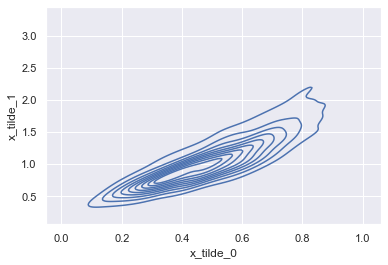

In [14]:
fig, ax = plt.subplots()

data = pd.DataFrame(pushforward_samples, columns=["x_tilde_0", "x_tilde_1"])
sns.kdeplot(data=data, x="x_tilde_0", y="x_tilde_1");
fig.savefig('computationally.png');

<Figure size 432x288 with 0 Axes>

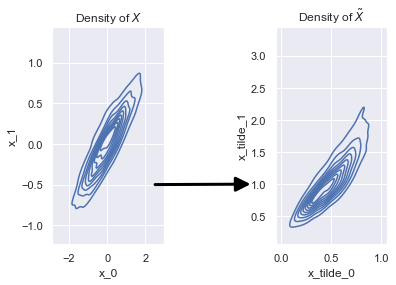

In [68]:
from matplotlib import patches, pyplot as plt

fig = plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
axes = axes.flatten()

# First subplot
data = pd.DataFrame(samples, columns=["x_0", "x_1"])
sns.kdeplot(data=data, x="x_0", y="x_1", ax=axes[0]);


# Second subplot
data = pd.DataFrame(pushforward_samples, columns=["x_tilde_0", "x_tilde_1"])
sns.kdeplot(data=data, x="x_tilde_0", y="x_tilde_1", ax=axes[1]);

# Add line from one subplot to the other
xyA = [2.5, -.5]
ax1.plot(*xyA, "o")
xyB = [-.3, 1]
ax2.plot(*xyB, "o")
# ConnectionPatch handles the transform internally so no need to get fig.transFigure
arrow = patches.ConnectionPatch(
    xyA,
    xyB,
    coordsA=axes[0].transData,
    coordsB=axes[1].transData,
    # Default shrink parameter is 0 so can be omitted
    color="black",
    arrowstyle="-|>",  # "normal" arrow
    mutation_scale=30,  # controls arrow head size
    linewidth=3,
);
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)
axes[0].set_title(r'Density of $X$')
axes[1].set_title(r'Density of $\tilde{X}$')

fig.patches.append(arrow);
fig.savefig('transformation.png');

In [7]:
def inv_transformation(x_tilde):
    return jnp.asarray([jax.scipy.special.logit(x_tilde[0]), jnp.log(x_tilde[1])])

In [8]:
x_tilde = jnp.column_stack(
    [jnp.linspace(0.001, 0.999, 1000), jnp.linspace(0.001, 3, 1000)]
)

In [9]:
pre_x_tilde = jax.vmap(inv_transformation)(x_tilde)

In [11]:
@functools.partial(jax.vmap, in_axes=(0, None))
@functools.partial(jax.vmap, in_axes=(None, 0))
def probability_density(x_0, x_1):
    return jnp.exp(distribution.log_prob(jnp.asarray([x_0, x_1])))

In [12]:
@functools.partial(jax.vmap, in_axes=(0, None))
@functools.partial(jax.vmap, in_axes=(None, 0))
def inv_det_jacobian_transform(x_0, x_1):
    return 1 / jnp.linalg.det(jax.jacobian(transformation)(jnp.asarray([x_0, x_1])))

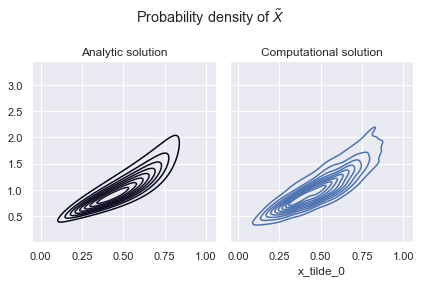

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax = ax.flatten()

ax[0].contour(
    x_tilde[:, 0],
    x_tilde[:, 1],
    (
        inv_det_jacobian_transform(pre_x_tilde[:, 0], pre_x_tilde[:, 1])
        * probability_density(pre_x_tilde[:, 0], pre_x_tilde[:, 1])
    ).T,
    levels=np.linspace(0.4, 80, 100),
)
sns.kdeplot(
    data=data,
    x="x_tilde_0",
    y="x_tilde_1",
    ax=ax[1],
)
ax[0].set_title("Analytic solution")
ax[1].set_title("Computational solution")
ax[1].set_ylabel("x_1")
fig.suptitle(r"Probability density of $\tilde{X}$")
fig.tight_layout();
fig.savefig('comparison.png');

In [ ]:
\tilde{X}